<a href="https://colab.research.google.com/github/Prajakta73/SpaceDebris-Classification/blob/main/code/QNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

ModuleNotFoundError: ignored

In [ ]:
import numpy
from numpy import genfromtxt

In [ ]:
'''(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
'''


x_train = genfromtxt('/content/train_x.csv', delimiter=',', dtype = float)
y_train = genfromtxt('/content/train_y.csv', delimiter=',', dtype = float)
x_test = genfromtxt('/content/test_x.csv', delimiter=',', dtype = float)
y_test = genfromtxt('/content/test_y.csv', delimiter=',', dtype = float)


x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0







In [ ]:
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 1314
Number of original test examples: 308


In [ ]:
x_train = numpy.arange(21528576).reshape(1314,128,128)
x_train = x_train.reshape((1314,128,128,1))


x_test = numpy.arange(5046272).reshape(308,128,128)
x_test = x_test.reshape((308,128,128,1))



In [ ]:
def filter_36(x, y):
    keep = (y == 0) | (y == 1)
    x, y = x[keep], y[keep]
    y = y == 1
    return x,y

In [ ]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 1314
Number of filtered test examples: 308


False


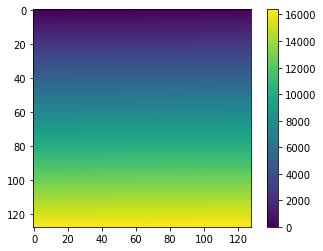

In [ ]:
print(y_train[0])

#plt.imshow(x_train[0, :, :, 0])
plt.imshow(x_train[0, :, :,0])
plt.colorbar()

In [ ]:
# Rescaling image size to 4*4 since it is very large for a qauntum algorithm to process

x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()



False


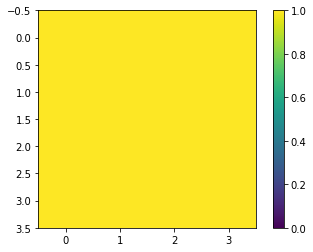

In [ ]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

In [ ]:
# Encoding data as quantum circuits 

THRESHOLD = 0.5

x_train_bin = np.array(x_train_small > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [ ]:

#The qubits that are greater than 0.5 , are passed and then rotated through an X gate.

def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(4, 4)
    circuit = cirq.Circuit()
    for i, value in enumerate(values):
        if value:
            circuit.append(cirq.X(qubits[i]))
    return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


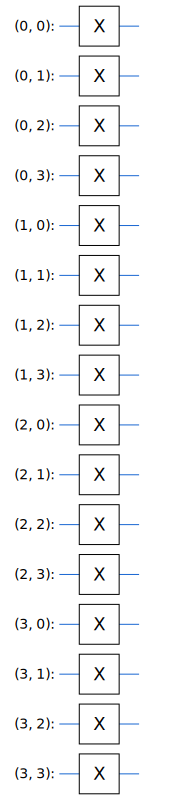

In [ ]:
SVGCircuit(x_train_circ[0])

In [ ]:
bin_img = x_train_bin[0,:,:]
indices = np.array(np.where(bin_img)).T
indices

array([[0, 0, 0],
       [0, 1, 0],
       [0, 2, 0],
       [0, 3, 0],
       [1, 0, 0],
       [1, 1, 0],
       [1, 2, 0],
       [1, 3, 0],
       [2, 0, 0],
       [2, 1, 0],
       [2, 2, 0],
       [2, 3, 0],
       [3, 0, 0],
       [3, 1, 0],
       [3, 2, 0],
       [3, 3, 0]])

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)




**QUANTUM NEURAL NETWORK IS BEING BUILT IN THE FOLLOWING SNIPPETS**

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout
    
    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

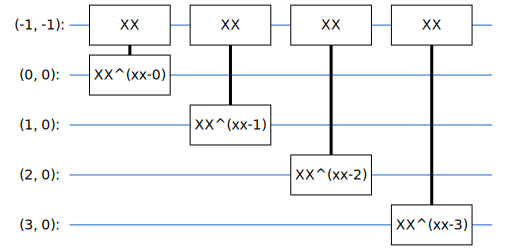

In [ ]:

demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(4,1),
                                   readout=cirq.GridQubit(-1,-1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()
    
    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    
    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
model_circuit, model_readout = create_quantum_model()

In [ ]:
# Build the Keras model.
from tensorflow.keras.layers import Dense

model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

![alt text](https://)**TRAING QUANTUM NEURAL NETWORK MODEL**

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=10,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge)
      )

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Train on 1314 samples, validate on 308 samples
Epoch 1/3
1314/1314 [==============================] - 710s 541ms/sample - loss: 0.9343 - hinge_accuracy: 0.5864 - val_loss: 0.8970 - val_hinge_accuracy: 0.6065
Epoch 2/3
1314/1314 [==============================] - 709s 540ms/sample - loss: 0.7073 - hinge_accuracy: 0.7011 - val_loss: 0.8149 - val_hinge_accuracy: 0.6065
Epoch 3/3
308/308 [==============================] - 5s 18ms/sample - loss: 0.7969 - hinge_accuracy: 0.6187


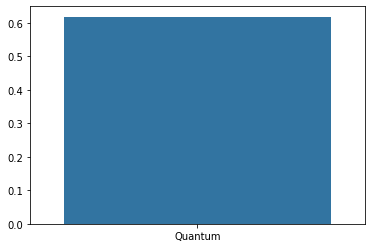

In [ ]:

qnn_accuracy = qnn_results[1]


sns.barplot(["Quantum"],
            [qnn_accuracy])
